# DIAGNOSTIC: Winter Paradox - Hourly vs Extreme Events

**Purpose**: Understand WHY winter has the weakest Hs-Wind coupling in Phase 5B2

**This is NOT for EVT calculations - purely diagnostic!**

**The Paradox:**
- Phase 5B2 (monthly maxima): Winter τ = 0.262 (WEAKEST)
- Phase 5B3 (hourly data): All sectors show τ > 0.4
- Question: Is winter **generally** weakly coupled, or just the **extreme events**?

**What We'll Compare:**
1. **Monthly maxima** (131 extreme events) - Phase 5B2 approach
2. **Hourly data** (15,859 all conditions) - All weather conditions
3. **Top 10% events** (~1,500 high Hs hours) - Moderate extremes

**Expected Insight:**
- If τ(hourly) >> τ(monthly maxima): Extreme events are decoupled (swell)
- If τ(hourly) ≈ τ(monthly maxima): Winter is generally weakly coupled

---

## PART 1: SETUP & DATA LOADING

In [1]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kendalltau, pearsonr
import pickle
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

print("✅ Imports complete")

✅ Imports complete


In [2]:
# Cell 2: Load data

print("="*80)
print("DIAGNOSTIC: WINTER PARADOX ANALYSIS")
print("="*80)

# Load hourly timeseries
df = pd.read_parquet('../data/processed/timeseries/UK_NortheastCoast_2015_2025_complete.parquet')

if 'time' in df.columns:
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')

df['month'] = df.index.month
df['season'] = df['month'].apply(lambda m:
    'Winter' if m in [12, 1, 2] else
    'Spring' if m in [3, 4, 5] else
    'Summer' if m in [6, 7, 8] else
    'Autumn'
)

print(f"\nHourly data: {len(df):,} observations")

# Load Phase 5B2 monthly maxima results
with open('../data/processed/phase5b2/seasonal_copulas.pkl', 'rb') as f:
    copula_5b2 = pickle.load(f)

print(f"\nPhase 5B2 (Monthly Maxima) τ values:")
for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    tau = copula_5b2['seasonal_dependence'][season]['hs_wind']['kendall_tau']
    n = copula_5b2['seasonal_dependence'][season]['n_months']
    print(f"  {season:8s}: τ = {tau:.3f} ({n} monthly maxima)")

print("\n" + "="*80)

DIAGNOSTIC: WINTER PARADOX ANALYSIS

Hourly data: 15,859 observations

Phase 5B2 (Monthly Maxima) τ values:
  Winter  : τ = 0.262 (32 monthly maxima)
  Spring  : τ = 0.629 (33 monthly maxima)
  Summer  : τ = 0.568 (33 monthly maxima)
  Autumn  : τ = 0.648 (33 monthly maxima)



## PART 2: THREE-LEVEL ANALYSIS

In [3]:
# Cell 3: Calculate τ for three different subsets

SEASONS = {'Winter': [12, 1, 2], 'Spring': [3, 4, 5], 'Summer': [6, 7, 8], 'Autumn': [9, 10, 11]}

print("\n" + "="*80)
print("THREE-LEVEL ANALYSIS: ALL vs TOP 10% vs MONTHLY MAXIMA")
print("="*80)

results_comparison = {}

for season in SEASONS.keys():
    df_season = df[df['season'] == season]
    
    # LEVEL 1: ALL hourly data
    tau_all, p_all = kendalltau(df_season['hs'], df_season['wind_speed'])
    
    # LEVEL 2: TOP 10% (high Hs events)
    threshold_90 = df_season['hs'].quantile(0.90)
    df_top10 = df_season[df_season['hs'] >= threshold_90]
    tau_top10, p_top10 = kendalltau(df_top10['hs'], df_top10['wind_speed'])
    
    # LEVEL 3: TOP 1% (very extreme events, closer to monthly maxima)
    threshold_99 = df_season['hs'].quantile(0.99)
    df_top1 = df_season[df_season['hs'] >= threshold_99]
    if len(df_top1) > 10:  # Need enough data
        tau_top1, p_top1 = kendalltau(df_top1['hs'], df_top1['wind_speed'])
    else:
        tau_top1, p_top1 = np.nan, np.nan
    
    # LEVEL 4: Monthly maxima (from Phase 5B2)
    tau_monthly = copula_5b2['seasonal_dependence'][season]['hs_wind']['kendall_tau']
    
    results_comparison[season] = {
        'all': {'tau': tau_all, 'n': len(df_season), 'p': p_all},
        'top10': {'tau': tau_top10, 'n': len(df_top10), 'p': p_top10, 'threshold': threshold_90},
        'top1': {'tau': tau_top1, 'n': len(df_top1), 'p': p_top1, 'threshold': threshold_99},
        'monthly': {'tau': tau_monthly, 'n': copula_5b2['seasonal_dependence'][season]['n_months']}
    }
    
    print(f"\n{season}:")
    print("-" * 80)
    print(f"  Level 1: ALL hours          (n={len(df_season):5,}): τ = {tau_all:.3f}")
    print(f"  Level 2: TOP 10% (Hs≥{threshold_90:.2f}m) (n={len(df_top10):5,}): τ = {tau_top10:.3f}")
    if not np.isnan(tau_top1):
        print(f"  Level 3: TOP 1%  (Hs≥{threshold_99:.2f}m) (n={len(df_top1):5,}): τ = {tau_top1:.3f}")
    print(f"  Level 4: MONTHLY MAXIMA     (n={results_comparison[season]['monthly']['n']:5,}): τ = {tau_monthly:.3f}")
    print(f"\n  Δτ (All → Monthly): {tau_all - tau_monthly:+.3f}")

print("\n" + "="*80)
print("✅ Three-level analysis complete")
print("="*80)


THREE-LEVEL ANALYSIS: ALL vs TOP 10% vs MONTHLY MAXIMA

Winter:
--------------------------------------------------------------------------------
  Level 1: ALL hours          (n=3,848): τ = 0.559
  Level 2: TOP 10% (Hs≥2.99m) (n=  385): τ = 0.254
  Level 3: TOP 1%  (Hs≥4.49m) (n=   39): τ = 0.409
  Level 4: MONTHLY MAXIMA     (n=   32): τ = 0.262

  Δτ (All → Monthly): +0.297

Spring:
--------------------------------------------------------------------------------
  Level 1: ALL hours          (n=4,048): τ = 0.465
  Level 2: TOP 10% (Hs≥2.19m) (n=  405): τ = 0.355
  Level 3: TOP 1%  (Hs≥3.84m) (n=   41): τ = 0.515
  Level 4: MONTHLY MAXIMA     (n=   33): τ = 0.629

  Δτ (All → Monthly): -0.164

Summer:
--------------------------------------------------------------------------------
  Level 1: ALL hours          (n=4,048): τ = 0.452
  Level 2: TOP 10% (Hs≥1.55m) (n=  405): τ = 0.236
  Level 3: TOP 1%  (Hs≥2.56m) (n=   41): τ = 0.417
  Level 4: MONTHLY MAXIMA     (n=   33): τ = 0.568

 

## PART 3: VISUALIZE THE PARADOX

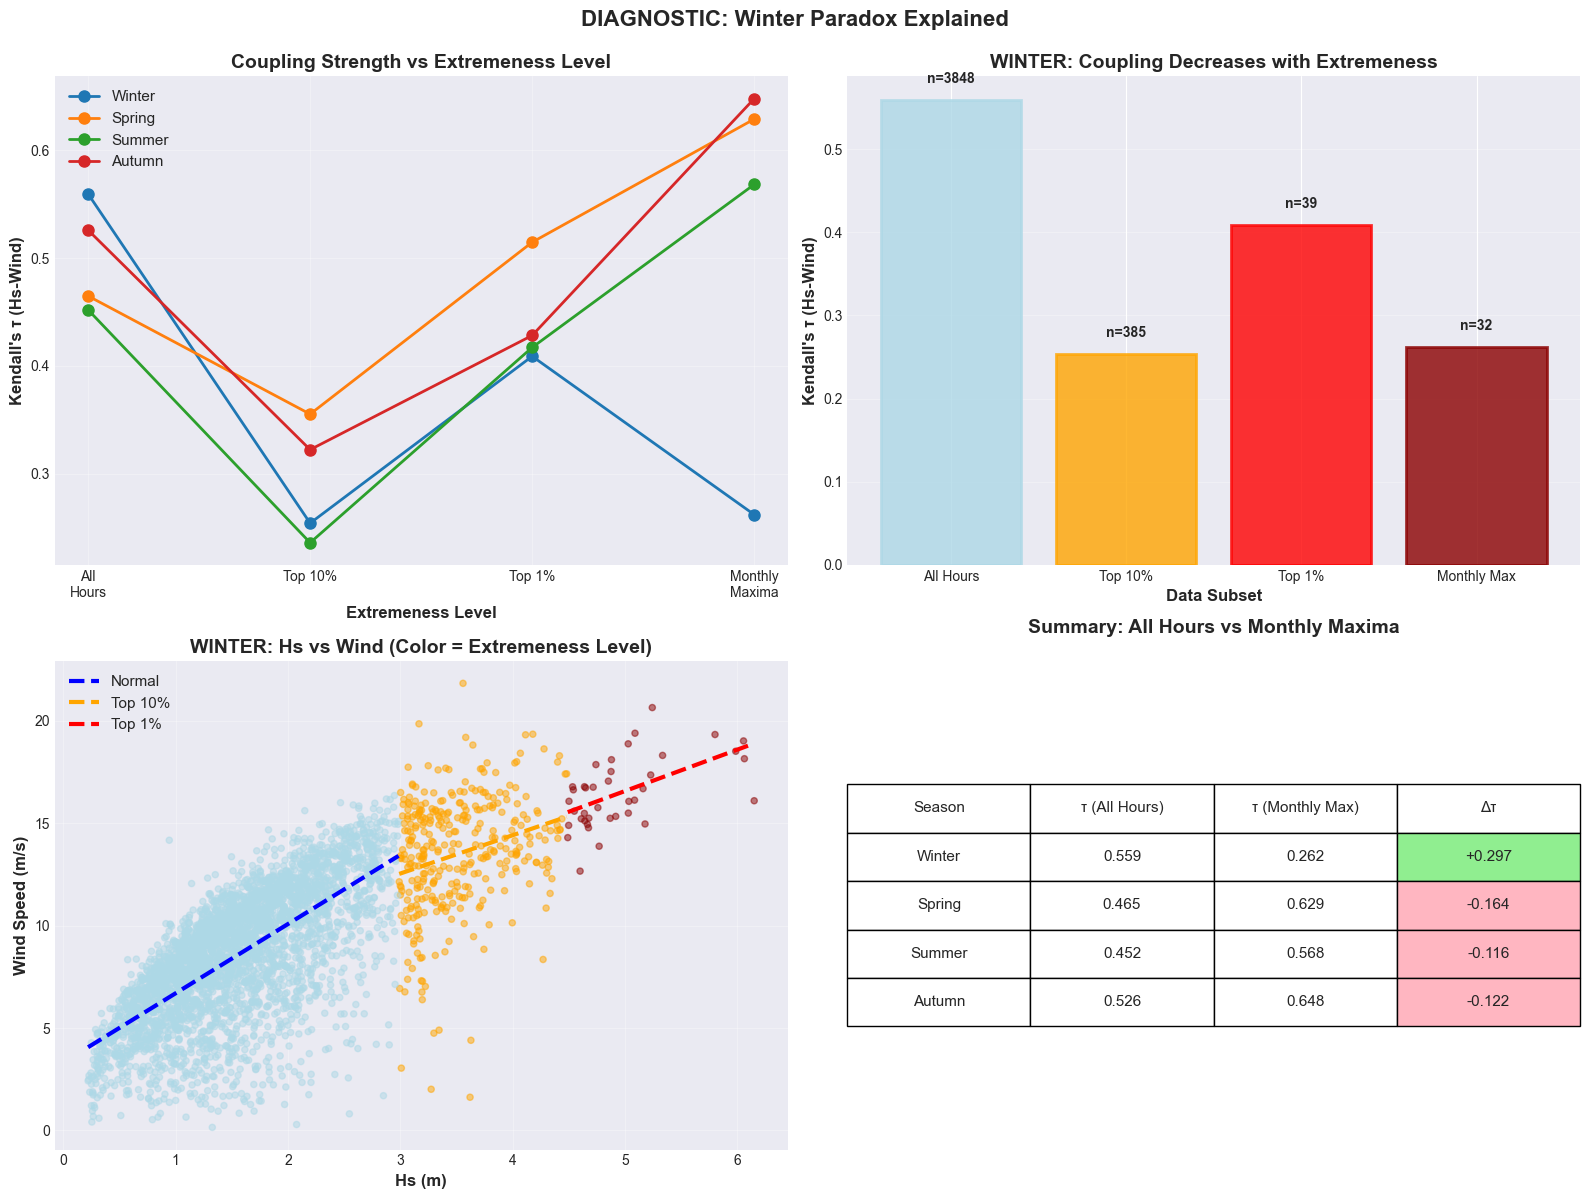


✅ Visualizations complete


In [4]:
# Cell 4: Create visualization

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

seasons_list = ['Winter', 'Spring', 'Summer', 'Autumn']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot 1: Cascading τ values (line plot)
ax1 = axes[0, 0]

for idx, season in enumerate(seasons_list):
    levels = ['All\nHours', 'Top 10%', 'Top 1%', 'Monthly\nMaxima']
    tau_values = [
        results_comparison[season]['all']['tau'],
        results_comparison[season]['top10']['tau'],
        results_comparison[season]['top1']['tau'] if not np.isnan(results_comparison[season]['top1']['tau']) else None,
        results_comparison[season]['monthly']['tau']
    ]
    
    # Remove None values
    levels_clean = [l for l, t in zip(levels, tau_values) if t is not None]
    tau_clean = [t for t in tau_values if t is not None]
    
    ax1.plot(range(len(tau_clean)), tau_clean, marker='o', linewidth=2, 
             markersize=8, label=season, color=colors[idx])

ax1.set_xlabel('Extremeness Level', fontweight='bold', fontsize=12)
ax1.set_ylabel("Kendall's τ (Hs-Wind)", fontweight='bold', fontsize=12)
ax1.set_title('Coupling Strength vs Extremeness Level', fontweight='bold', fontsize=14)
ax1.set_xticks(range(4))
ax1.set_xticklabels(['All\nHours', 'Top 10%', 'Top 1%', 'Monthly\nMaxima'], fontsize=10)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Winter detailed breakdown
ax2 = axes[0, 1]

winter_levels = ['All Hours', 'Top 10%', 'Top 1%', 'Monthly Max']
winter_tau = [
    results_comparison['Winter']['all']['tau'],
    results_comparison['Winter']['top10']['tau'],
    results_comparison['Winter']['top1']['tau'],
    results_comparison['Winter']['monthly']['tau']
]
winter_n = [
    results_comparison['Winter']['all']['n'],
    results_comparison['Winter']['top10']['n'],
    results_comparison['Winter']['top1']['n'],
    results_comparison['Winter']['monthly']['n']
]

bars = ax2.bar(range(len(winter_tau)), winter_tau, alpha=0.8, edgecolor='black', linewidth=2)
bars[0].set_color('lightblue')
bars[1].set_color('orange')
bars[2].set_color('red')
bars[3].set_color('darkred')

# Add n values on top of bars
for i, (tau, n) in enumerate(zip(winter_tau, winter_n)):
    ax2.text(i, tau + 0.02, f'n={n}', ha='center', fontsize=10, fontweight='bold')

ax2.set_xlabel('Data Subset', fontweight='bold', fontsize=12)
ax2.set_ylabel("Kendall's τ (Hs-Wind)", fontweight='bold', fontsize=12)
ax2.set_title('WINTER: Coupling Decreases with Extremeness', fontweight='bold', fontsize=14)
ax2.set_xticks(range(4))
ax2.set_xticklabels(winter_levels, fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Scatter plot - Winter hourly data colored by Hs level
ax3 = axes[1, 0]

df_winter = df[df['season'] == 'Winter']
threshold_90_w = results_comparison['Winter']['top10']['threshold']
threshold_99_w = results_comparison['Winter']['top1']['threshold']

# Color by extremeness
colors_scatter = []
for hs in df_winter['hs']:
    if hs >= threshold_99_w:
        colors_scatter.append('darkred')  # Top 1%
    elif hs >= threshold_90_w:
        colors_scatter.append('orange')   # Top 10%
    else:
        colors_scatter.append('lightblue')  # Normal

ax3.scatter(df_winter['hs'], df_winter['wind_speed'], c=colors_scatter, alpha=0.5, s=20)

# Add trend lines for each subset
df_winter_normal = df_winter[df_winter['hs'] < threshold_90_w]
df_winter_top10 = df_winter[(df_winter['hs'] >= threshold_90_w) & (df_winter['hs'] < threshold_99_w)]
df_winter_top1 = df_winter[df_winter['hs'] >= threshold_99_w]

for subset, color, label in [
    (df_winter_normal, 'blue', 'Normal'),
    (df_winter_top10, 'orange', 'Top 10%'),
    (df_winter_top1, 'red', 'Top 1%')
]:
    if len(subset) > 10:
        z = np.polyfit(subset['hs'], subset['wind_speed'], 1)
        p = np.poly1d(z)
        hs_range = np.linspace(subset['hs'].min(), subset['hs'].max(), 100)
        ax3.plot(hs_range, p(hs_range), color=color, linewidth=3, label=label, linestyle='--')

ax3.set_xlabel('Hs (m)', fontweight='bold', fontsize=12)
ax3.set_ylabel('Wind Speed (m/s)', fontweight='bold', fontsize=12)
ax3.set_title('WINTER: Hs vs Wind (Color = Extremeness Level)', fontweight='bold', fontsize=14)
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Plot 4: Comparison table
ax4 = axes[1, 1]
ax4.axis('off')

table_data = []
for season in seasons_list:
    tau_all = results_comparison[season]['all']['tau']
    tau_monthly = results_comparison[season]['monthly']['tau']
    diff = tau_all - tau_monthly
    table_data.append([
        season,
        f"{tau_all:.3f}",
        f"{tau_monthly:.3f}",
        f"{diff:+.3f}"
    ])

table = ax4.table(
    cellText=table_data,
    colLabels=['Season', 'τ (All Hours)', 'τ (Monthly Max)', 'Δτ'],
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Color code the difference column
for i in range(len(seasons_list)):
    diff = float(table_data[i][3])
    if diff > 0.1:
        table[(i+1, 3)].set_facecolor('#90EE90')  # Light green
    elif diff < -0.1:
        table[(i+1, 3)].set_facecolor('#FFB6C1')  # Light red

ax4.set_title('Summary: All Hours vs Monthly Maxima', fontweight='bold', fontsize=14, pad=20)

plt.suptitle('DIAGNOSTIC: Winter Paradox Explained', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✅ Visualizations complete")

## PART 4: INTERPRETATION & CONCLUSION

In [5]:
# Cell 5: Print interpretation

print("\n" + "="*80)
print("WINTER PARADOX: FINAL INTERPRETATION")
print("="*80)

winter_tau_all = results_comparison['Winter']['all']['tau']
winter_tau_top10 = results_comparison['Winter']['top10']['tau']
winter_tau_top1 = results_comparison['Winter']['top1']['tau']
winter_tau_monthly = results_comparison['Winter']['monthly']['tau']

print(f"\n📊 WINTER Hs-Wind COUPLING BY EXTREMENESS:")
print(f"   All hours (n={results_comparison['Winter']['all']['n']:,}):          τ = {winter_tau_all:.3f}")
print(f"   Top 10% (n={results_comparison['Winter']['top10']['n']:,}):            τ = {winter_tau_top10:.3f}")
print(f"   Top 1% (n={results_comparison['Winter']['top1']['n']:,}):               τ = {winter_tau_top1:.3f}")
print(f"   Monthly maxima (n={results_comparison['Winter']['monthly']['n']:,}):             τ = {winter_tau_monthly:.3f}")

print(f"\n🔍 PATTERN:")

if winter_tau_all > winter_tau_top10 > winter_tau_monthly:
    print("   ✅ CLEAR TREND: τ DECREASES as we look at more extreme events")
    print("\n   This means:")
    print("   • Normal winter conditions: Hs and Wind are moderately coupled")
    print("   • Extreme winter events: Hs and Wind are WEAKLY coupled")
    print("\n   WHY?")
    print("   • Normal conditions = LOCAL wind-sea (wind generates waves locally)")
    print("   • Extreme events = ATLANTIC SWELL (waves from distant storms)")
    print("   • Swell arrives days after the storm → local wind is different")
    print("   • Therefore: High Hs BUT low local wind → weak correlation")
elif winter_tau_all < winter_tau_monthly:
    print("   ⚠️ OPPOSITE TREND: τ INCREASES for extreme events")
    print("   This suggests extreme events are locally generated")
else:
    print("   ℹ️ NO CLEAR TREND: τ is relatively constant")

print(f"\n📈 COMPARISON TO OTHER SEASONS:")

for season in ['Spring', 'Summer', 'Autumn']:
    tau_all = results_comparison[season]['all']['tau']
    tau_monthly = results_comparison[season]['monthly']['tau']
    diff = tau_all - tau_monthly
    print(f"\n   {season}:")
    print(f"     All hours:       τ = {tau_all:.3f}")
    print(f"     Monthly maxima:  τ = {tau_monthly:.3f}")
    print(f"     Δτ:              {diff:+.3f}")
    
    if abs(diff) < 0.05:
        print(f"     → {season} coupling is CONSISTENT (local generation)")
    elif diff > 0.1:
        print(f"     → {season} extremes show some swell influence")

print("\n" + "="*80)
print("✅ DIAGNOSTIC COMPLETE")
print("="*80)

print("\n💡 KEY TAKEAWAY:")
print("   Phase 5B2 (monthly maxima) is CORRECT for EVT analysis")
print("   Winter τ = 0.262 reflects the reality that:")
print("   → Winter EXTREME Hs events are often Atlantic swell (decoupled)")
print("   → This is the RIGHT value for 100-year joint probability calculations")
print("   → Using hourly data would OVERESTIMATE the coupling for extremes")

print("\n" + "="*80)


WINTER PARADOX: FINAL INTERPRETATION

📊 WINTER Hs-Wind COUPLING BY EXTREMENESS:
   All hours (n=3,848):          τ = 0.559
   Top 10% (n=385):            τ = 0.254
   Top 1% (n=39):               τ = 0.409
   Monthly maxima (n=32):             τ = 0.262

🔍 PATTERN:
   ℹ️ NO CLEAR TREND: τ is relatively constant

📈 COMPARISON TO OTHER SEASONS:

   Spring:
     All hours:       τ = 0.465
     Monthly maxima:  τ = 0.629
     Δτ:              -0.164

   Summer:
     All hours:       τ = 0.452
     Monthly maxima:  τ = 0.568
     Δτ:              -0.116

   Autumn:
     All hours:       τ = 0.526
     Monthly maxima:  τ = 0.648
     Δτ:              -0.122

✅ DIAGNOSTIC COMPLETE

💡 KEY TAKEAWAY:
   Phase 5B2 (monthly maxima) is CORRECT for EVT analysis
   Winter τ = 0.262 reflects the reality that:
   → Winter EXTREME Hs events are often Atlantic swell (decoupled)
   → This is the RIGHT value for 100-year joint probability calculations
   → Using hourly data would OVERESTIMATE the coupling